In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
tr = pd.read_csv('../input/X_train.csv')
te = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')
ss = pd.read_csv('../input/sample_submission.csv')

In [3]:
# target.groupby(['surface','group_id'])['series_id'].apply(list)
# target[target['surface']=='concrete'].groupby(['surface','group_id'])['series_id'].size()
# groups_excluding = [5,50,63]

In [4]:
unique_surface = target["surface"].unique()


In [5]:
cross_validation_mapping = {}
for surface in unique_surface:
    if surface in["a","hard_tiles","carpet"]:
        continue
    size_array = target[target['surface']==surface].groupby(['surface','group_id'])['series_id'].size()
    groups_excluding = size_array[size_array<20].reset_index()['group_id']
    group_list = target[target['surface']==surface]['group_id'].unique()
    l3 = [x for x in group_list if x not in groups_excluding]
    folds = KFold(n_splits=5, shuffle=True, random_state=59)
    score = []
    for times, (trn_idx, val_idx) in enumerate(folds.split(l3,l3)):
        if surface not in cross_validation_mapping :
            print(surface)
            cross_validation_mapping[surface] = {}
            cross_validation_mapping[surface]["train"] = []
            cross_validation_mapping[surface]["cross_validation"] = []
        temp_2 = np.array(l3)[trn_idx]
        temp_2 = np.append(temp_2, groups_excluding)
        cross_validation_mapping[surface]["train"].append(temp_2)
#         cross_validation_mapping[surface]["train"].append(np.array(l3)[trn_idx])
#         cross_validation_mapping[surface]["train"].append(np.array(groups_excluding))
        cross_validation_mapping[surface]["cross_validation"].append(np.array(l3)[val_idx])

fine_concrete
concrete
soft_tiles
tiled
soft_pvc
hard_tiles_large_space
wood


In [6]:
trn_idx

array([ 0,  2,  3,  4,  5,  6,  8,  9, 10])

In [7]:
groups_excluding

0     2
1    24
2    67
Name: group_id, dtype: int64

In [8]:
carpet = {}
carpet["train"] = []
carpet["test"] = []
group_list = target[target['surface']=="carpet"]['group_id'].unique()
group_list
folds = KFold(n_splits=4, shuffle=True, random_state=59)
score = []
for times, (trn_idx, val_idx) in enumerate(folds.split(group_list,group_list)):
    carpet["train"].append(np.array(group_list)[trn_idx])
    carpet["test"].append(np.array(group_list)[val_idx])
carpet_extra_train = np.array([25,52,60])
carpet_extra_test = np.array([7])
carpet["train"].append(carpet_extra_train)
carpet["test"].append(carpet_extra_test)
cross_validation_mapping["carpet"] = {}
cross_validation_mapping["carpet"]["train"] = carpet["train"]
cross_validation_mapping["carpet"]["cross_validation"] = carpet["test"]

In [9]:
hard_tile_series_id = target[target["group_id"]==27]['series_id']
folds = KFold(n_splits=5, shuffle=True, random_state=59)
score = []
hard_tiles_mappings = {}
hard_tiles_mappings["train"] = []
hard_tiles_mappings["cross_validation"] = []
for times, (trn_idx, val_idx) in enumerate(folds.split(hard_tile_series_id,hard_tile_series_id)):
    hard_tiles_mappings["train"].append(np.array(hard_tile_series_id)[trn_idx])
    hard_tiles_mappings["cross_validation"].append(np.array(hard_tile_series_id)[val_idx])

In [10]:
train_labels = target['surface']

In [11]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 0.5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [12]:
tr = fe(tr)
te = fe(te)

In [13]:
tr.fillna(0, inplace = True)
te.fillna(0, inplace = True)
tr.replace(-np.inf, 0, inplace = True)
tr.replace(np.inf, 0, inplace = True)
te.replace(-np.inf, 0, inplace = True)
te.replace(np.inf, 0, inplace = True)

In [14]:
from IPython.display import HTML
import base64
def create_download_link(df, title = "Download ", filename = "data.csv"):  
    title = title + filename
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [15]:
train_labels= target['surface']
train_concat = pd.concat([tr,target],axis=1)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle


In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_concat["surface"] = le.fit_transform(target["surface"])


In [18]:
import itertools    


In [19]:
hard_tiles_mappings["train"]
len(hard_tiles_mappings["cross_validation"][1])

4

In [20]:
i =0
scores = []
confusion_matrix_data = {}
confusion_matrix_data["predictions"] = []
confusion_matrix_data["actual"]= []
while i<5:
    print(i)
    tr_features = pd.DataFrame()
    tr_label = pd.Series()
    cv_features = pd.DataFrame()
    cv_label = pd.Series()
    for surface in unique_surface:
        if (surface != "hard_tiles"):
            temp = train_concat[train_concat["group_id"].isin(cross_validation_mapping[surface]["train"][i])]
        else :
            temp = (train_concat.iloc[hard_tiles_mappings["train"][i]])
        
        temp_label = temp["surface"]
        temp_feature = temp.drop(columns=['group_id','surface','series_id'])
        tr_features = tr_features.append(temp_feature)
        tr_label = tr_label.append(temp_label)
        
        if (surface != "hard_tiles"):
            temp = train_concat[train_concat["group_id"].isin(cross_validation_mapping[surface]["cross_validation"][i])]
        else:    
            temp = (train_concat.iloc[hard_tiles_mappings["cross_validation"][i]])
        temp_label = temp["surface"]
        temp_feature = temp.drop(columns=['group_id','surface','series_id'])
        cv_features = cv_features.append(temp_feature)
        cv_label = cv_label.append(temp_label)
    random_forest = RandomForestClassifier(n_estimators = 50, random_state = 50)
    print(tr_features.shape)
    print(cv_features.shape)
    print(tr_features.shape[0]*100/train_concat.shape[0])
    shuffle_train = tr_features.copy()
    shuffle_train["surface"] = tr_label
    shuffle_train =  shuffle(shuffle_train)
    tr_features_2 = shuffle_train.drop(columns=['surface'])
    tr_label_2 = shuffle_train["surface"]
    random_forest.fit(tr_features_2, tr_label_2)
    
    shuffle_cv = cv_features.copy()
    shuffle_cv["surface"] = cv_label
    shuffle_cv =  shuffle(shuffle_cv)
    cv_features_2 = shuffle_cv.drop(columns=['surface'])
    cv_label_2 = shuffle_cv["surface"]
    score = random_forest.score(cv_features_2, cv_label_2)
    confusion_matrix_data["predictions"].append(random_forest.predict(cv_features_2))
    confusion_matrix_data["actual"].append(cv_label_2)
    scores.append(score)
    i += 1


0
(2874, 171)
(906, 171)
75.43307086614173
1
(2947, 171)
(815, 171)
77.3490813648294
2
(3046, 171)
(724, 171)
79.94750656167979
3
(2972, 171)
(787, 171)
78.00524934383202
4
(3204, 171)
(559, 171)
84.09448818897638


In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
confusion_matrix(confusion_matrix_data["predictions"][0], confusion_matrix_data["actual"][0])

array([[  1,   0,   0,   0,   4,   0,   0,   0,   5],
       [ 14, 130,   5,   0,   8,   6,  13,   7,  52],
       [ 10,   0,   7,   0,   3,   0,   4,   4,   1],
       [  0,   0,   0,   2,   0,   0,   1,   0,   0],
       [ 10,   3,   3,   0,  46,   0,   0,   3,   0],
       [ 26,   3,   1,   0,   2, 117,  39,   4,  29],
       [  1,   2,   5,   0,   0,   4,  51,   0,   1],
       [  5,   6,   0,   0,   0,   0,   1,  56,   5],
       [  4,   0,  39,   3,   8,   8,   5,  36, 103]])

In [23]:
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

In [24]:
scores

[0.5662251655629139,
 0.5496932515337424,
 0.3494475138121547,
 0.5883100381194409,
 0.4669051878354204]

In [25]:
scores

[0.5662251655629139,
 0.5496932515337424,
 0.3494475138121547,
 0.5883100381194409,
 0.4669051878354204]

In [26]:
# confusion_matrix_data['predictions'][1].shape
print(1)

1


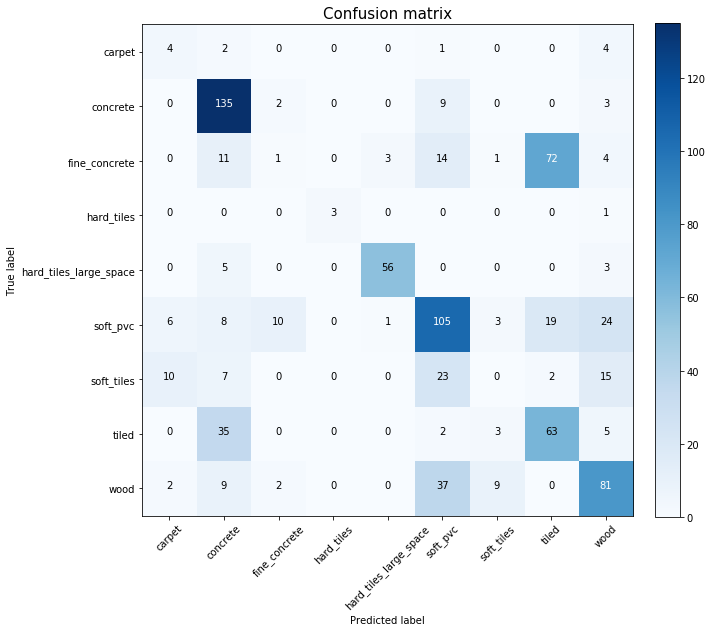

In [27]:
plot_confusion_matrix(confusion_matrix_data['actual'][1], confusion_matrix_data["predictions"][1], le.classes_)

In [28]:
target["surface"].value_counts()["hard_tiles"]*.2

4.2

In [29]:
l_group = target.groupby('group_id')['series_id'].apply(list)

In [30]:
train_3 = {}
val_3 = {}

In [31]:
for series_id_arr in l_group:
    folds = KFold(n_splits=5, shuffle=True, random_state=59)
    if len(series_id_arr) <6:
        continue
    for i, (trn_idx, val_idx) in enumerate(folds.split(series_id_arr,series_id_arr)):
        if i not in train_3:
            train_3[i] = []
        if i not in val_3:
            val_3[i] = []
        train_3[i].extend(np.array(series_id_arr)[trn_idx].tolist())
        val_3[i].extend(np.array(series_id_arr)[val_idx].tolist())
#         train_3[i] = np.concatenate([train_3[i],np.array(series_id_arr)[trn_idx]])
#         val_3[i].append(np.array(series_id_arr)[val_idx])

In [32]:
# flat_list = [item for sublist in train_3[0] for item in sublist]
# len(flat_list)
len(train_3)
print(len(train_3[0]))
print(len(val_3[0]))
print(len(train_3[1]))
print(len(val_3[1]))

3012
790
3029
773


In [33]:
# train_concat.head(1)
print(1)

1


In [34]:
j = 0
scores = []
while j < 5:
    train_data_3 = train_concat[train_concat['series_id'].isin(train_3[j])]
    train_data_3_fe = train_data_3.drop(columns=['group_id','surface','series_id'])
    train_data_3_label = train_data_3["surface"]
    cv_data_3 = train_concat[train_concat['series_id'].isin(val_3[j])]
    cv_data_3_fe = cv_data_3.drop(columns=['group_id','surface','series_id'])
    cv_data_3_label = cv_data_3["surface"]
    random_forest = RandomForestClassifier(n_estimators = 50, random_state = 50)
    random_forest.fit(train_data_3_fe, train_data_3_label)
    score = random_forest.score(cv_data_3_fe, cv_data_3_label)
    scores.append(score)
    j = j +1


In [35]:
scores

[0.8936708860759494,
 0.8952134540750324,
 0.8961384820239681,
 0.9183400267737617,
 0.9014844804318488]